# Additional stimulation protocols
This notebook shows different ways to apply what was seen in previous examples. The goal is to show how to use it and modifiy it for particular cases.

## Compiling mechanisms

In [7]:
!nrnivmodl ../mechanisms

/home/eromero/BBP/.venv/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/eromero/BBP/BlueCelluLab/examples/7-Extra-Simulation
Mod files: "../mechanisms/../mechanisms/Ca.mod" "../mechanisms/../mechanisms/CaDynamics_DC0.mod" "../mechanisms/../mechanisms/CaDynamics_E2.mod" "../mechanisms/../mechanisms/Ca_HVA.mod" "../mechanisms/../mechanisms/Ca_HVA2.mod" "../mechanisms/../mechanisms/Ca_LVAst.mod" "../mechanisms/../mechanisms/DetAMPANMDA.mod" "../mechanisms/../mechanisms/DetGABAAB.mod" "../mechanisms/../mechanisms/GluSynapse.mod" "../mechanisms/../mechanisms/Ih.mod" "../mechanisms/../mechanisms/Im.mod" "../mechanisms/../mechanisms/K_Pst.mod" "../mechanisms/../mechanisms/K_Tst.mod" "../mechanisms/../mechanisms/KdShu2007.mod" "../mechanisms/../mechanisms/NaTa_t.mod" "../mechanisms/../mechanisms/NaTg.mod" "../mechanisms/../mechanisms/NaTs2_t.mod" "../mechanisms/../mechanisms/Nap_Et2.mod" "../mechanisms/../mechanisms/ProbAMPANMDA_EMS.mod" "../mechanisms/../mechanisms/ProbGABAAB_EMS.mod" "../mechanisms/../mechanisms/SK_E2.mod" "../mechanisms/../mechanisms/SKv3

**Reminder**: The compiled mechanisms need to be provided before importing bluecellulab.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap

import neuron
from bluecellulab import Cell
from bluecellulab.simulation import Simulation
from bluecellulab.tools import search_threshold_current
from bluecellulab.circuit.circuit_access import EmodelProperties

from bluecellulab.stimulus import StimulusFactory

## Loading the cell

In [9]:
# Define the base directory
base_dir = Path("../1-singlecell/")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cADpyr_L2TPC.hoc"
morph_file = base_dir / "morphology" / "rr110330_C3_idA.asc"

In [10]:
emodel_properties = EmodelProperties(threshold_current=0.03203125,
                                     holding_current=-0.11,
                                     AIS_scaler=1.11)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Reset function

In [11]:
def reset_cell(hoc_file, morph_file, emodel_properties):
    """ Resets the cell for new stimulation
        Input:
            hoc_file:
            morph_file:
            cell: neuron
        Output:
            cell: neuron
            sim: Simulation
    """
    cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
    sim =Simulation()
    sim.add_cell(cell)
    return cell, sim

## Stimulations
### Stimulation function for each protocols

In [22]:
def plot_stim(axs, time, voltage, stim_amp, duration, stim):
    """ Plot stimulation
        Input:
            axs: subplot axes
            time: in in ms
            voltage: voltage response in mV
            stim_amp: int in ms
            duration: int
            stim: StimulusFactory
        Output:
            Plot
    """
    # Plot voltage over time on the first subplot
    axs[0].plot(time, voltage, marker='.', label=f'{stim_amp}nA', markersize=2)
    axs[0].set_title('Time vs Voltage')
    axs[0].set_ylabel("Voltage [mV]")
    axs[0].set_xlim(left=0)  # Make the plot start from 0 on the x-axis
    # axs[0].legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Plot injected current over time on the second subplot
    axs[1].plot(stim.time, stim.current, label=f'{stim_amp:.3f}nA', drawstyle='steps-post', markersize=2, markeredgewidth=1)
    axs[1].set_title('Time vs Injected Current')
    axs[1].set_xlim(left=0)  # Make the plot start from 0 on the x-axis
    # axs[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')

def step_current_stim(duration, stim_start, stim_end, stim_amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike = False):
    """ generate a step current and plot it
        Input:
            duration: int
            stim_start: int in ms
            stim_end: int in ms
            amp: int for nA
        Output:
            step: StimulusFactory.step
            time: in ms
            voltage: in mV
    """
    # reset cell
    cell, sim = reset_cell(hoc_file, morph_file, emodel_properties)
    # set stimulus type, here step
    stim_factory = StimulusFactory(dt=0.1)
    if segment == 'soma':
        cell.start_recording_spikes(None, location='soma', threshold=-10)
    step = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=stim_amp)
    if segment != 'soma':
        neuron_section = cell.sections[segment]
        cell.add_voltage_recording(neuron_section, 0.5)
        cell.inject_current_waveform(t_content= step.time, i_content= step.current, section=neuron_section, segx=0.5)
    else:
        neuron_section = cell.soma
        cell.inject_current_waveform(t_content= step.time, i_content= step.current)
    #stimulation
    complete_duration = stim_start + duration + stim_end
    sim.run(complete_duration, cvode=False)
    print("Done.")
    
    time = cell.get_time()
    if segment != 'soma':
        voltage = cell.get_voltage_recording(neuron_section, 0.5)
        return step, time, voltage
    else:
        voltage = cell.get_soma_voltage()
        spikes = cell.get_recorded_spikes(location="soma", threshold=-10)
        if spike:
            return step, time, voltage, spikes
        else:
            return step, time, voltage


def train_pulse(stim_factory, stim_start, duration, stim_end, stim_amp):
    """ train pulse
        Input:
            stim_factory: StimulusFactory()
            stim_start: int in ms
            stim_end: int in ms
            amp: int for nA
        Output:
            Combined_stimulus: a train pulse
            combined_duration: int
    """
    stim_start = stim_start/2
    stim_end = stim_end/2
    stim1 = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=stim_amp)
    stim2 = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=0.0)
    combined_stimulus = stim1 + stim2 + stim1 + stim2 + stim1 + stim2
    combined_duration = (stim_start + duration + stim_end) * 6
    return combined_stimulus, combined_duration

def ramp_step_pulse(stim_factory):
    """ train pulse
        Input:
            stim_factory: StimulusFactory()
        Output:
            Combined_stimulus: a train pulse
            combined_duration: int
    """
    delay = 250
    duration = 1000
    post_delay = 250
    stim2 = stim_factory.ramp(pre_delay=delay, duration=duration, post_delay=delay, amplitude = 0.5)
    stim3 = stim_factory.step(pre_delay=delay, duration=duration, post_delay=delay, amplitude=0.21)
    stim4 = stim_factory.step(pre_delay=delay, duration=duration, post_delay=delay, amplitude=0.0)
    combined_stimulus = stim2 + stim4 + stim3 + stim4 + stim2
    combined_duration = (delay + duration + post_delay) * 5
    return combined_stimulus, combined_duration

def ramp(stim_factory, stim_start, duration, stim_end, stim_amp):
    """ ramp
        Input:
            stim_factory: StimulusFactory()
            stim_start: int in ms
            stim_end: int in ms
            amp: int for nA
        Output:
            Combined_stimulus: a ramp
    """
    stim = stim_factory.ramp(pre_delay=stim_start, duration=duration, post_delay=stim_end, amplitude=stim_amp)
    return stim

def any_current_stim(total_duration, stim, cell, sim, stim_amp):
    """ generate any pulse current
        Input:
            duration: int
            
        Output:
            time: in ms
            voltage: in mV
    """
    # set stimulus type, here step
    print("Injecting current in cell")
    cell.inject_current_waveform(t_content= stim.time, i_content= stim.current)
    print("Done")
    #stimulation
    print(f"Running the simulation for {stim_amp} nA")
    sim.run(total_duration, cvode=False)
    print("Done.")
    time , voltage = cell.get_time(), cell.get_soma_voltage()

    return time, voltage

def run_stim(stim_start, duration, stim_end, stim_amp, stim_type):
    print("Generating current stimulation")
    stim_factory = StimulusFactory(dt=0.1)
    total_duration = stim_start + duration + stim_end
    if stim_type == "step":
        stim = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=stim_amp)
    elif stim_type == "train_pulse":
        stim, total_duration = train_pulse(stim_factory, stim_start, duration, stim_end, stim_amp)
    elif stim_type == "ramp_step":
        stim, total_duration = ramp_step_pulse(stim_factory)
    elif stim_type == "ramp":
        stim = ramp(stim_factory, stim_start, duration, stim_end, stim_amp)
    else:
        print("Not a known stimulation")
        stim = stim_factory
    print("Done")
    return stim, total_duration

def run_sim(duration, stim_start, stim_end, stim_amp, stim_type, hoc_file, morph_file, emodel_properties):
    # reset cell
    cell, sim = reset_cell(hoc_file, morph_file, emodel_properties)
    stim, total_duration = run_stim(stim_start, duration, stim_end, stim_amp, stim_type)
    time, voltage = any_current_stim(total_duration, stim, cell, sim, stim_amp)

    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
    plot_stim(axs, time, voltage, stim_amp, total_duration, stim)
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
    plt.show()

    return stim, time, voltage


### 1. Step current injection for rheobase and negative step current

In [13]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
rheobase = search_threshold_current(
        template_name = hoc_file,
        morphology_path = morph_file,
        template_format = "v6",
        emodel_properties = emodel_properties,
        hyp_level = 0,
        inj_start = stim_start,
        inj_stop = stim_start + duration,
        min_current = 0.001,
        max_current = 0.5,
        current_precision = 0.001
    )

Done.
Done.
Done.
Done.


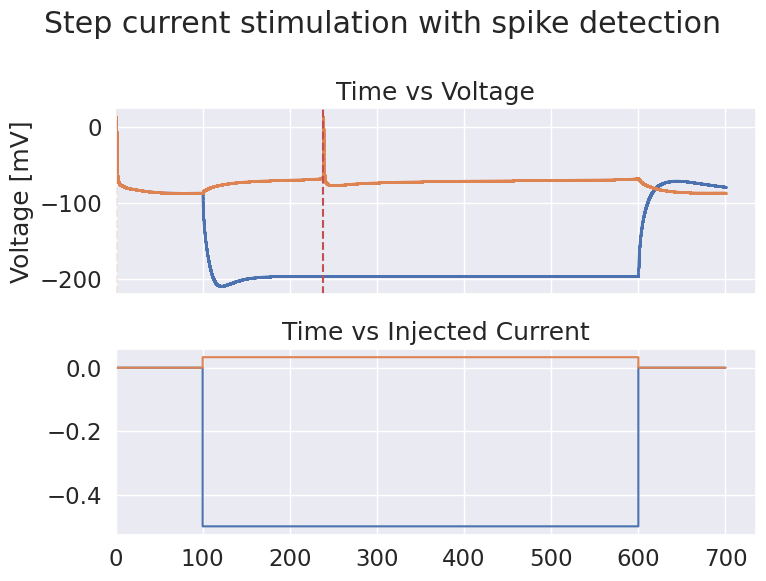

In [23]:
list_amp = [-.5, rheobase] # [nA]
a_section = 5
segment = f'apic[{a_section}]'

steps = []
times = []
times_soma = []
voltages = []
voltages_soma = []
spikes = []
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle(f"Step current stimulation with spike detection")
for amp in list_amp:
    step, time_soma, voltage_soma = step_current_stim(duration, stim_start, stim_end, amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike=False)
    step, time, voltage, spike = step_current_stim(duration, stim_start, stim_end, amp, hoc_file, morph_file, emodel_properties, spike=True)
    plot_stim(axs, time_soma, voltage_soma, amp, duration, step)
    # add spikes to the plot as dashed lines
    for spik in spike:
        axs[0].axvline(spik, c="r", linestyle="--")
    spikes.append(spike)
    steps.append(step)
    times.append(time)
    times_soma.append(time_soma)
    voltages.append(voltage)
    voltages_soma.append(voltage_soma)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()

### 2. Multiple negative step current injections

Running the simulation for -1.966837890625 nA
Done.
Running the simulation for -1.8621010485197367 nA
Done.
Running the simulation for -1.7573642064144737 nA
Done.
Running the simulation for -1.6526273643092104 nA
Done.
Running the simulation for -1.5478905222039474 nA
Done.
Running the simulation for -1.4431536800986842 nA
Done.
Running the simulation for -1.338416837993421 nA
Done.
Running the simulation for -1.2336799958881577 nA
Done.
Running the simulation for -1.1289431537828947 nA
Done.
Running the simulation for -1.0242063116776317 nA
Done.
Running the simulation for -0.9194694695723684 nA
Done.
Running the simulation for -0.8147326274671052 nA
Done.
Running the simulation for -0.7099957853618419 nA
Done.
Running the simulation for -0.6052589432565789 nA
Done.
Running the simulation for -0.5005221011513157 nA
Done.
Running the simulation for -0.39578525904605266 nA
Done.
Running the simulation for -0.2910484169407894 nA
Done.
Running the simulation for -0.18631157483552618 nA
D

/tmp/ipykernel_10988/1205350708.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area


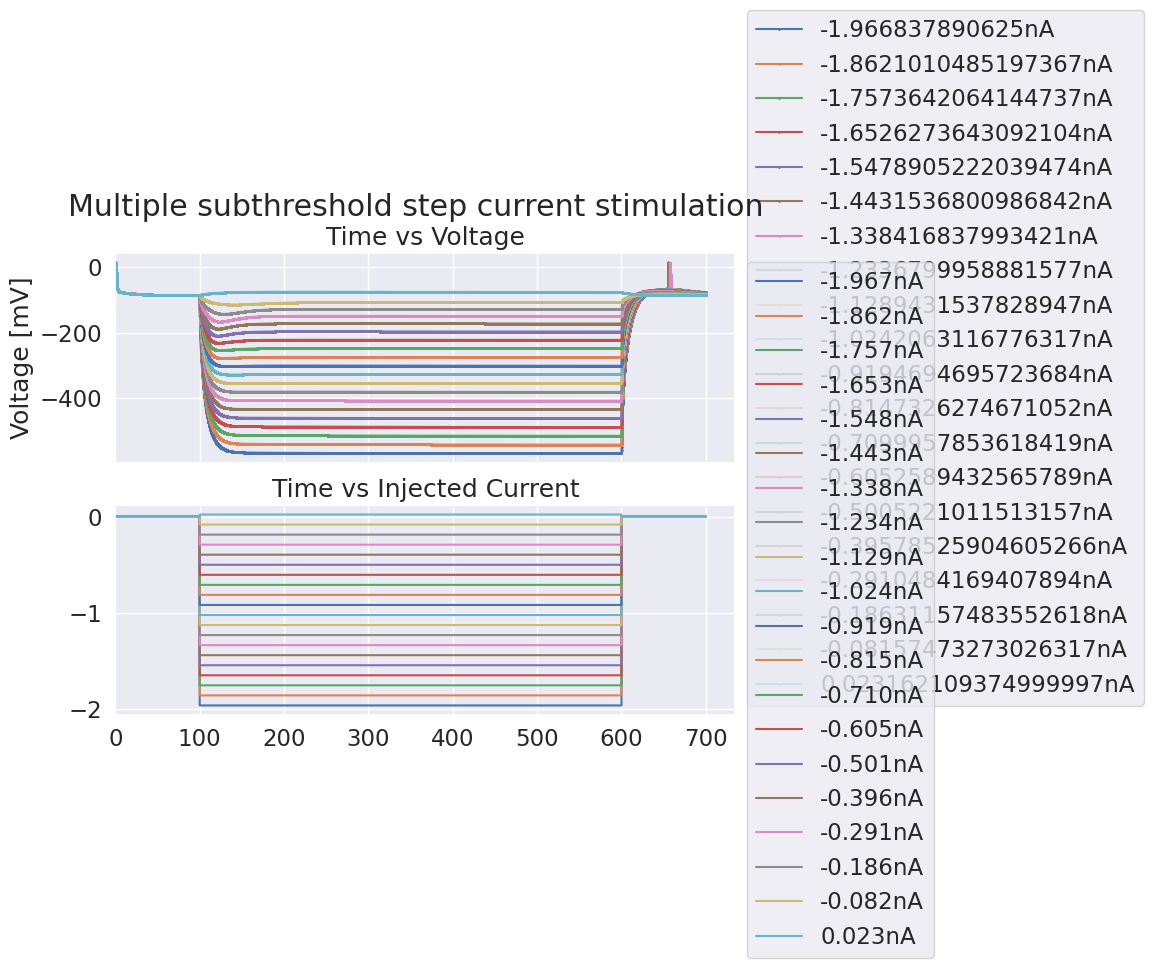

In [21]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
list_amp = np.linspace(rheobase-2, rheobase-.01, 20) # [nA]

steps = []
times = []
voltages = []
# spikes = []
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle(f'Multiple subthreshold step current stimulation')
for amp in list_amp:
    step, time, voltage = step_current_stim(duration, stim_start, stim_end, amp, hoc_file, morph_file, emodel_properties)
    plot_stim(axs, time, voltage, amp, duration, step)
    # spikes.append(spike)
    steps.append(step)
    times.append(time)
    voltages.append(voltage)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()


### 3. IV Plot
With the previous data obtain in multiple negative step current injections, we can plot the IV curve.

In [16]:
def steady_state_voltage_stimend(stim_start, duration, voltage, t):
    stim_end = stim_start + duration
    begin_time = stim_end - 0.1 * duration
    end_time = stim_end
    steady_state = np.mean(voltage[np.where((t < end_time) & (t >= begin_time))])
    return steady_state

def plot_IV(stim_start, stim_end, voltages, times, list_amp):
    steady_states = []
    for voltage, t in zip(voltages, times):
        steady_state = steady_state_voltage_stimend(stim_start, stim_end, voltage, t)
        steady_states.append(steady_state)
    sns.set(font_scale=1.5)
    plt.plot(list_amp, steady_states, marker='o')
    plt.title("I-V curve")
    plt.xlabel("Injected current [nA]")
    plt.ylabel("Steady state voltage [mV]")
    plt.tight_layout()
    plt.show()
    return steady_states

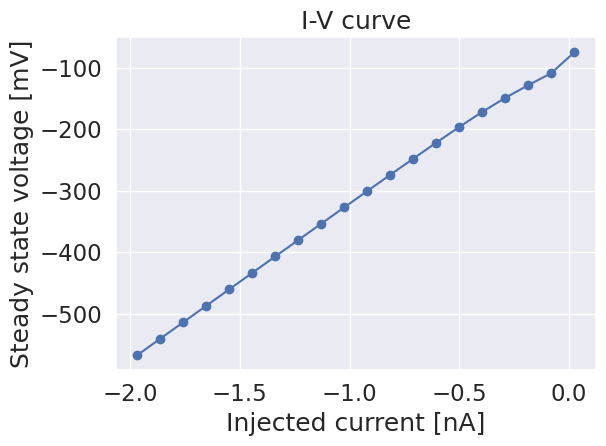

In [17]:
steady_states = plot_IV(stim_start, stim_end, voltages, times, list_amp)

### 4. Multiple positive step current injections

Running the simulation for 0.033162109375 nA
Done.
Running the simulation for 0.1961440972222222 nA
Done.
Running the simulation for 0.35912608506944443 nA
Done.
Running the simulation for 0.5221080729166666 nA
Done.
Running the simulation for 0.6850900607638888 nA
Done.
Running the simulation for 0.848072048611111 nA
Done.
Running the simulation for 1.0110540364583334 nA
Done.
Running the simulation for 1.1740360243055554 nA
Done.
Running the simulation for 1.3370180121527777 nA
Done.
Running the simulation for 1.5 nA
Done.
Running the simulation for 1.5 nA
Done.
Running the simulation for 1.8888888888888888 nA
Done.
Running the simulation for 2.2777777777777777 nA
Done.
Running the simulation for 2.666666666666667 nA
Done.
Running the simulation for 3.0555555555555554 nA
Done.
Running the simulation for 3.4444444444444446 nA
Done.
Running the simulation for 3.8333333333333335 nA
Done.
Running the simulation for 4.222222222222222 nA
Done.
Running the simulation for 4.611111111111111 n

/tmp/ipykernel_10988/2680811321.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area


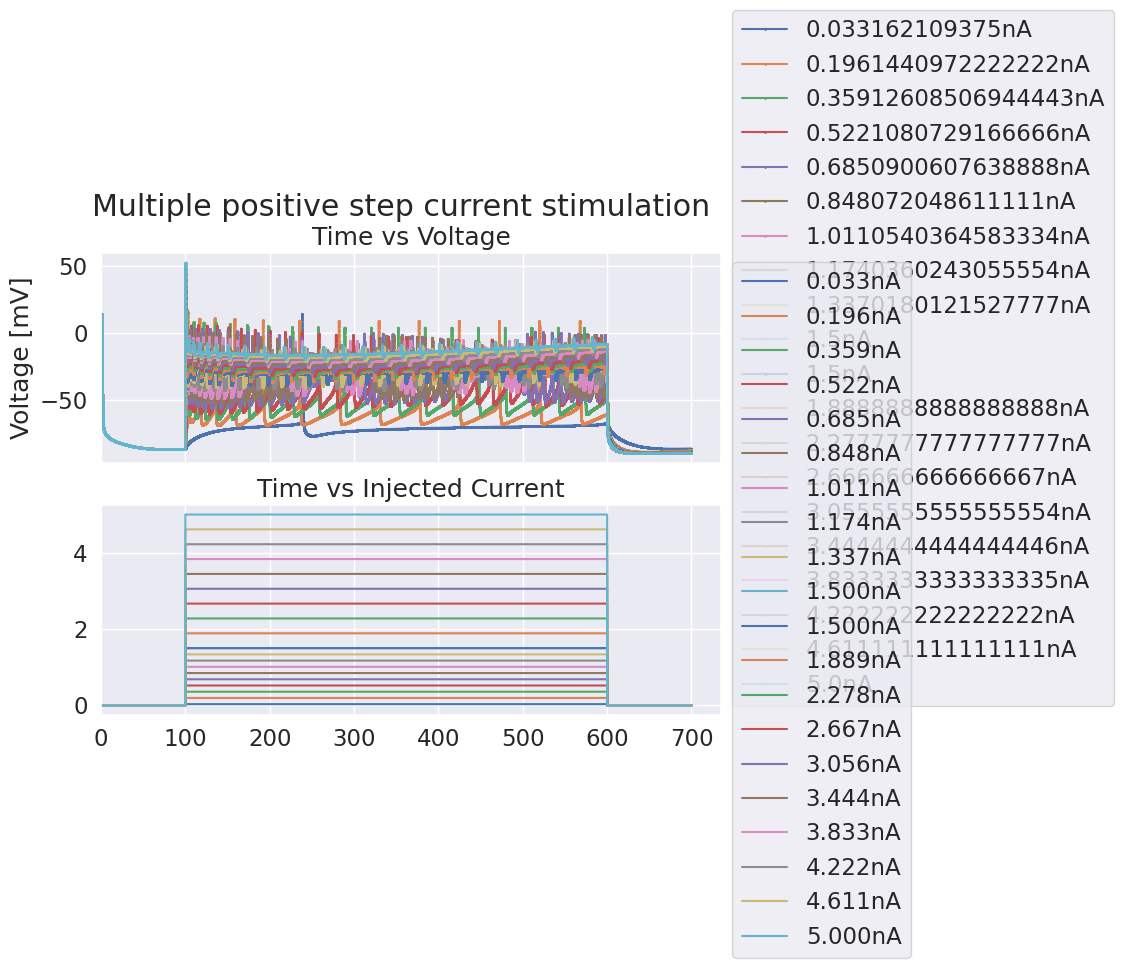

In [18]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
first_amp = np.linspace(rheobase, 1.5, 10)
list_amp = np.concatenate((first_amp, np.linspace(1.5, 5, 10)), axis=None) # [nA]


steps = []
times = []
voltages = []
spikes  = []
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle(f'Multiple positive step current stimulation')
for amp in list_amp:
    step, time, voltage, spike = step_current_stim(duration, stim_start, stim_end, amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike=True)
    plot_stim(axs, time, voltage, amp, duration, step)
    spikes.append(spike)
    steps.append(step)
    times.append(time)
    voltages.append(voltage)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()

### 5. FI curve
With the previous data obtain in multiple positive step current injections, we can plot the FI curve.

In [19]:
def plot_FI(list_amp, spikes):
    spike_count = [len(spike) for spike in spikes]
    plt.plot(list_amp, spike_count, marker='o')
    plt.title("F-I curve")
    plt.xlabel("Current (nA)")
    plt.ylabel("Spike count")
    plt.tight_layout()
    plt.show()
    return spike_count

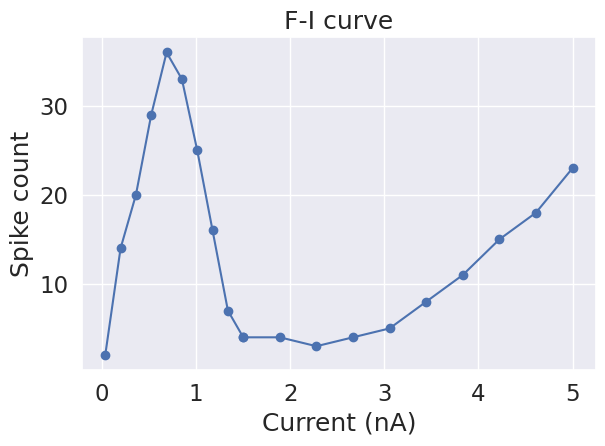

In [20]:
spike_count = plot_FI(list_amp, spikes)

### 6. Voltage Sag accross different distances

In [26]:
def get_all_distance(all_section, cell):
    """ get_all_distance
        Calculate the distance to soma for all sections
        Input:
            cell: neuron
        Output:
            all_distance: dictionary
    """
    print('Getting all distances')
    all_distance = {}
    for section in all_section:
        distance_to_soma = neuron.h.distance(cell.soma(0.5), section)
        # store in dictionary: key = section name, value = distance to soma
        all_distance[section] = distance_to_soma
    return all_distance

def sample_elements(dist_dict, min_dist):
    """ sample_elements
        Sample elements from dict
        Input:
            dist_dict: dict
            min_dist: int
        Output:
            sampled_distance: dict
    """
    # sort dictionary by value
    sorted_dict = dict(sorted(dist_dict.items(), key=lambda item: item[1]))
    sampled_distance = {}
    # get first element of all_distance
    first_section = list(sorted_dict.keys())[0]
    sampled_distance[first_section] = sorted_dict[first_section]
    
    for section, distance in sorted_dict.items():
        if distance - sorted_dict[first_section] > min_dist:
            sampled_distance[section] = distance
            first_section = section

    return sampled_distance

def get_best_sample(all_distance, max_size):
    """ get_best_sample
        Get the best sample
        Input:
            all_distance: dict
        Output:
            sampled_distance: list
    """
    if len(all_distance) <= max_size:
        return list(all_distance.keys())
    else:
        # using sample_elements function find the min_dist which gives ~max_size with max 50 iterations
        i = 0
        sampled_distance = sample_elements(all_distance, i)
        
        while len(sampled_distance) > max_size:
            sampled_distance = sample_elements(all_distance, i)
            i += 1
        print(len(sampled_distance))
        print(i)
        # for i in range(0, 500, 1):
        #     sampled_distance = sample_elements(all_distance, i)
        #     if len(sampled_distance) <= max_size:
        #         print(len(sampled_distance))
        #         print(i)
        #         break
        return list(sampled_distance.keys())

In [66]:
cell, sim = reset_cell(hoc_file, morph_file, emodel_properties)
number_of_sections = 25

all_segments_dend = []
all_segments_apic = []
for section in cell.sections:
    for sec in cell.sections[section]:
        if "dend" in str(sec):
            all_segments_dend.append(sec)
        if "apic" in str(sec):
            all_segments_apic.append(sec)

all_segments = all_segments_dend + all_segments_apic

all_distances_dend = get_all_distance(all_segments_dend, cell)
all_distances_apic = get_all_distance(all_segments_apic, cell)

sampled_all_section_dend = get_best_sample(all_distances_dend, number_of_sections)
sampled_all_section_apic = get_best_sample(all_distances_apic, number_of_sections)

sampled_all_section = sampled_all_section_dend + sampled_all_section_apic
sampled_all_section = [str(sec) for sec in sampled_all_section]

Getting all distances
Getting all distances
25
5
25
12


In [69]:
# ----------------------- V Sage simulation ------------------------------
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
stim_amp = -.5 # [nA]

v_sag_times = []
v_sag_voltages = []
v_sag_voltages_soma = []
all_distance = []
# getting all distances
for section in sampled_all_section:
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    distance_to_soma = neuron.h.distance(cell.soma(0.5), a_section(record_pos))
    all_distance.append(distance_to_soma)
# getting traces and simulating
for section in sampled_all_section:
    cell, sim = reset_cell(hoc_file=hoc_file, morph_file=morph_file, emodel_properties=emodel_properties)
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    cell.add_voltage_recording(a_section, record_pos)
    # set stimulus type, here step
    stim_factory = StimulusFactory(dt=0.1)
    step = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=stim_amp)
    cell.inject_current_waveform(t_content = step.time, i_content = step.current, section = a_section, segx = record_pos)
    complete_duration = stim_start + duration + stim_end
    sim.run(complete_duration, cvode=False)
    print("Done.")
    time , voltage, voltage_soma = cell.get_time(), cell.get_voltage_recording(a_section, record_pos), cell.get_soma_voltage()
    v_sag_times.append(time)
    v_sag_voltages.append(voltage)
    v_sag_voltages_soma.append(voltage_soma)
#----------------------- V Sag data in dendrite ------------------------------
v_sags = []
steady_state_voltages = []
peak_currents = []
for voltage, t in zip(v_sag_voltages, v_sag_times):
    steady_state = steady_state_voltage_stimend(stim_start, duration, voltage, t)
    peak_current = min(voltage)
    v_sag = steady_state/ peak_current * 100
    v_sags.append(v_sag)
    steady_state_voltages.append(steady_state)
    peak_currents.append(peak_current)

sampled_all_section = list(map(str, sampled_all_section))
# plot steady state voltage vs time and peak current vs time
df_sag = pd.DataFrame({'Steady state voltage': steady_state_voltages, 'Peak current': peak_currents, 'V sag': v_sags})
df_sag['Distance to soma'] = all_distance
df_sag['Section'] = sampled_all_section
    
dict_sag = {'time': v_sag_times, 'voltage': v_sag_voltages, 'distance': all_distance, 'section': sampled_all_section}


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9e40 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9e40
                                                      ^


Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab82e0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab82e0
                                                      ^


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9330 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9330
                                                      ^


Done.
Done.
Done.
Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4abbcd0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4abbcd0
                                                      ^


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0
                                                      ^


Done.
Done.
Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab93f0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab93f0
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0
                                                      ^


Done.
Done.
Done.
Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4abbe80 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4abbe80
                                                      ^


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4abb5e0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4abb5e0
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4aba3e0
                                                      ^


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab89d0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab89d0
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab8490 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab8490
                                                      ^


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9e70 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9e70
                                                      ^


Done.
Done.
Done.
Done.
Done.
Done.


exp(700.189) out of range, returning exp(700)
exp(700.527) out of range, returning exp(700)
exp(700.863) out of range, returning exp(700)
exp(701.198) out of range, returning exp(700)
No more errno warnings during this execution


Done.
Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4abb010 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4abb010
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9330 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9330
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9150 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab9150
                                                      ^


Done.


NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4a4ab89d0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4a4ab89d0
                                                      ^


Done.
Done.


/tmp/ipykernel_10988/24051413.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_sag, x='Distance to soma', y='V sag', palette='viridis')


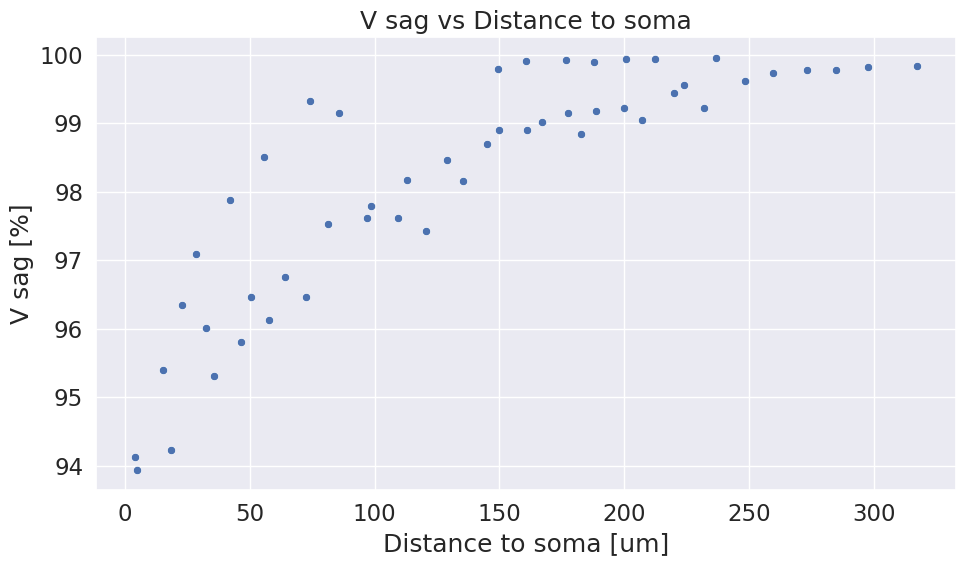

In [72]:
plt.figure(figsize=(10, 6))
plt.title('V sag vs Distance to soma')
sns.scatterplot(data=df_sag, x='Distance to soma', y='V sag', palette='viridis')
plt.xlabel('Distance to soma [um]')
plt.ylabel('V sag [%]')
plt.tight_layout()
plt.show()

### 7. EPSP accross different distances

In [91]:
def EPSP(cell, sim, a_section, record_pos):
    """ EPSP
        Calculate the EPSP ratio by stimulating for 1 section
        Input:
            cell: neuron
            sim: Simulation
            a_section: list of sections
            record_pos: float pos in section
        Output:
            cell: neuron
            sim: Simulation
            current_vector: neuron.h.Vector()
            dendrite_max_epsp_index: int
            soma_max_epsp_index: int
            dendrite_max_epsp: float
            soma_max_epsp: float
            dendrite_psp_amplitude: float in mV
            soma_psp_amplitude: float in mV
            dendrite_voltage_base: float in mV
            soma_voltage_base: float in mV
            
    """
    # set recording
    
    #a_section = cell.sections[section_name]
    cell.add_voltage_recording(a_section, record_pos)
    
    # synapse and current recording
    onset = 300.0
    tau = 10.0
    gmax = 0.0001
    e = 0.0
    synapse = cell.add_alpha_synapse(onset, tau, gmax, e, section=a_section)
    
    current_vector = neuron.h.Vector()
    _ = current_vector.record(synapse._ref_i)
    # simulation
    duration = 450
    dt = 0.1
    # neuron_globals = NeuronGlobals.get_instance()
    # neuron_globals.temperature = 34.0
    # neuron_globals.v_init = -70.0
    sim.run(duration, cvode=False, dt=dt)
    #get ratio
    
    voltage = cell.get_voltage_recording(a_section, record_pos)
    soma_voltage = cell.get_soma_voltage()

    voltage_base_offset = 100
    voltage_base_start_index = int(voltage_base_offset / dt)
    protocol_start_index = int(onset / dt)
    protocol_end_index = int((duration) / dt)  # extending till end of simulation

    dendrite_voltage_base = np.median(voltage[voltage_base_start_index:protocol_start_index])
    soma_voltage_base = np.median(soma_voltage[voltage_base_start_index:protocol_start_index])



    dendrite_max_epsp = max(voltage[protocol_start_index:protocol_end_index])
    soma_max_epsp = max(soma_voltage[protocol_start_index:protocol_end_index])
    dendrite_psp_amplitude = dendrite_max_epsp - dendrite_voltage_base
    soma_psp_amplitude = soma_max_epsp - soma_voltage_base

    dendrite_max_epsp_index = np.argmax(voltage[protocol_start_index:protocol_end_index]) + protocol_start_index
    soma_max_epsp_index = np.argmax(soma_voltage[protocol_start_index:protocol_end_index]) + protocol_start_index

    return cell, sim, current_vector, dendrite_max_epsp_index, soma_max_epsp_index, dendrite_max_epsp, soma_max_epsp, dendrite_psp_amplitude, soma_psp_amplitude, dendrite_voltage_base, soma_voltage_base 

def EPSP_data(dendrite_psp_amplitude, soma_psp_amplitude, dendrite_max_epsp_index, soma_max_epsp_index, dt):
    """ EPSP_data
        Calculate the EPSP ratio by stimulating for all sections
        Input:
            dendrite_psp_amplitude: float
            soma_psp_amplitude: float
            dendrite_max_epsp_index: int
            soma_max_epsp_index: int
            dt: float
            cell: neuron
            sim: Simulation
        Output:
            psp ratio: float
            delay: float in ms
    """
    psp_amplitude_ratio = dendrite_psp_amplitude / soma_psp_amplitude
    delay = (soma_max_epsp_index - dendrite_max_epsp_index) * dt

    return psp_amplitude_ratio, delay

In [77]:
all_segments_dend = []
all_segments_apic = []
for section in cell.sections:
    for sec in cell.sections[section]:
        if "dend" in str(sec):
            all_segments_dend.append(sec)
        if "apic" in str(sec):
            all_segments_apic.append(sec)

all_segments = all_segments_dend + all_segments_apic

all_distances_dend = get_all_distance(all_segments_dend, cell)
all_distances_apic = get_all_distance(all_segments_apic, cell)

sampled_all_section_dend = get_best_sample(all_distances_dend, number_of_sections)
sampled_all_section_apic = get_best_sample(all_distances_apic, number_of_sections)

sampled_all_section = sampled_all_section_dend + sampled_all_section_apic
sampled_all_section = [str(sec) for sec in sampled_all_section]

Getting all distances
Getting all distances
25
5
25
12


In [92]:
all_dendrite_max_epsp_index = []
all_soma_max_epsp_index = []
all_dendrite_max_epsp = []
all_soma_max_epsp = []
all_dendrite_psp_amplitude = []
all_soma_psp_amplitude = []
all_dendrite_voltage_base = []
all_soma_voltage_base = []

all_psp_amplitude_ratio = []
all_delay = []
all_time = []
all_voltage = []
all_soma_voltage = []
all_distance = []


for section in sampled_all_section:
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    distance_to_soma = neuron.h.distance(cell.soma(0.5), a_section(record_pos))
    all_distance.append(distance_to_soma)

for section in sampled_all_section:
    cell, sim = reset_cell(hoc_file=hoc_file, morph_file=morph_file, emodel_properties=emodel_properties)
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    # gettting values
    cell, sim, current_vector, dendrite_max_epsp_index, soma_max_epsp_index, dendrite_max_epsp, soma_max_epsp, dendrite_psp_amplitude, soma_psp_amplitude, dendrite_voltage_base, soma_voltage_base = EPSP(cell, sim, a_section, record_pos)
    psp_amplitude_ratio, delay = EPSP_data(dendrite_psp_amplitude, soma_psp_amplitude, dendrite_max_epsp_index, soma_max_epsp_index, 0.1)
    time = cell.get_time()
    voltage = cell.get_voltage_recording(a_section, record_pos)
    soma_voltage = cell.get_soma_voltage()

    # append all in corresponding list
    all_dendrite_max_epsp_index.append(dendrite_max_epsp_index)
    all_soma_max_epsp_index.append(soma_max_epsp_index)
    all_dendrite_max_epsp.append(dendrite_max_epsp)
    all_soma_max_epsp.append(soma_max_epsp)
    all_dendrite_psp_amplitude.append(dendrite_psp_amplitude)
    all_soma_psp_amplitude.append(soma_psp_amplitude)
    all_dendrite_voltage_base.append(dendrite_voltage_base)
    all_soma_voltage_base.append(soma_voltage_base)
    all_psp_amplitude_ratio.append(psp_amplitude_ratio)
    all_delay.append(delay)
    all_time.append(time)
    all_voltage.append(voltage)
    all_soma_voltage.append(soma_voltage)



NEURON: cADpyr_L2TPC_bluecellulab_0x7fb489733280 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb489733280
                                                      ^
NEURON: cADpyr_L2TPC_bluecellulab_0x7fb489733640 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb489733640
                                                      ^
NEURON: cADpyr_L2TPC_bluecellulab_0x7fb489757af0 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb489757af0
                                                      ^
NEURON: cADpyr_L2TPC_bluecellulab_0x7fb489755e70 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb489755e70
                                                      ^
NEURON: cADpyr_L2TPC_bluecellulab_0x7fb4897abb50 : a template cannot be redefined
 near line 24
 begintemplate cADpyr_L2TPC_bluecellulab_0x7fb4897abb50
                

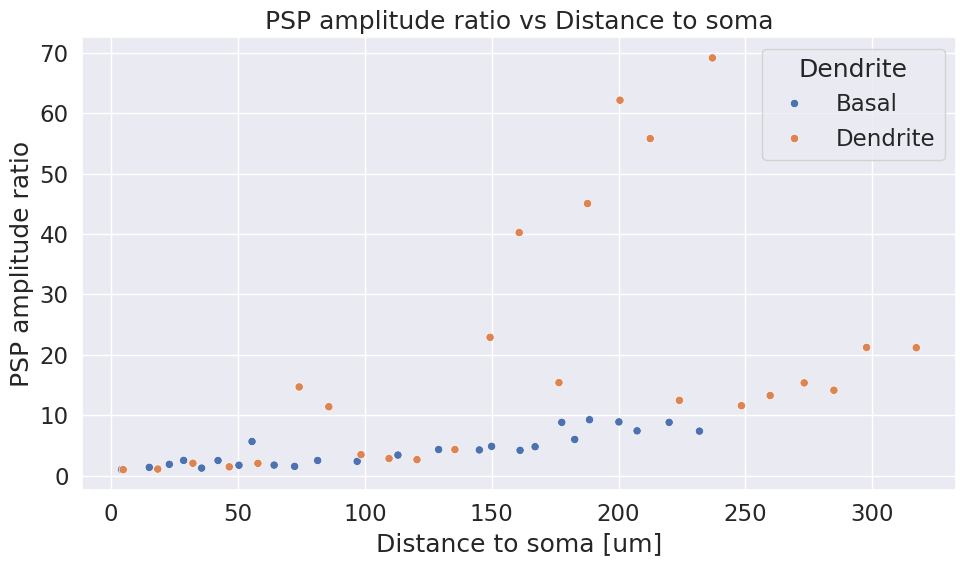

In [87]:
df_epsp = pd.DataFrame({'Dendrite max EPSP index': all_dendrite_max_epsp_index, 'Soma max EPSP index': all_soma_max_epsp_index, 'Dendrite max EPSP': all_dendrite_max_epsp, 'Soma max EPSP': all_soma_max_epsp, 'Dendrite PSP amplitude': all_dendrite_psp_amplitude, 'Soma PSP amplitude': all_soma_psp_amplitude, 'Dendrite voltage base': all_dendrite_voltage_base, 'Soma voltage base': all_soma_voltage_base, 'PSP amplitude ratio': all_psp_amplitude_ratio, 'Delay': all_delay, 'Time': all_time, 'Voltage': all_voltage, 'Soma voltage': all_soma_voltage, 'Distance to soma': all_distance})
df_epsp['Section'] = sampled_all_section
# set true if apical
df_epsp['Dendrite'] = df_epsp['Section'].str.contains('apic')
df_epsp['Dendrite'] = df_epsp['Dendrite'].apply(lambda x: 'Dendrite' if x == True else 'Basal')

plt.figure(figsize=(10, 6))
plt.title('PSP amplitude ratio vs Distance to soma')
sns.scatterplot(data=df_epsp, x='Distance to soma', y='PSP amplitude ratio', hue = 'Dendrite')
plt.xlabel('Distance to soma [um]')
plt.ylabel('PSP amplitude ratio')
plt.tight_layout()
plt.show()